## Лекция 7. Обучение свёрточной нейронной сети в PyTorch

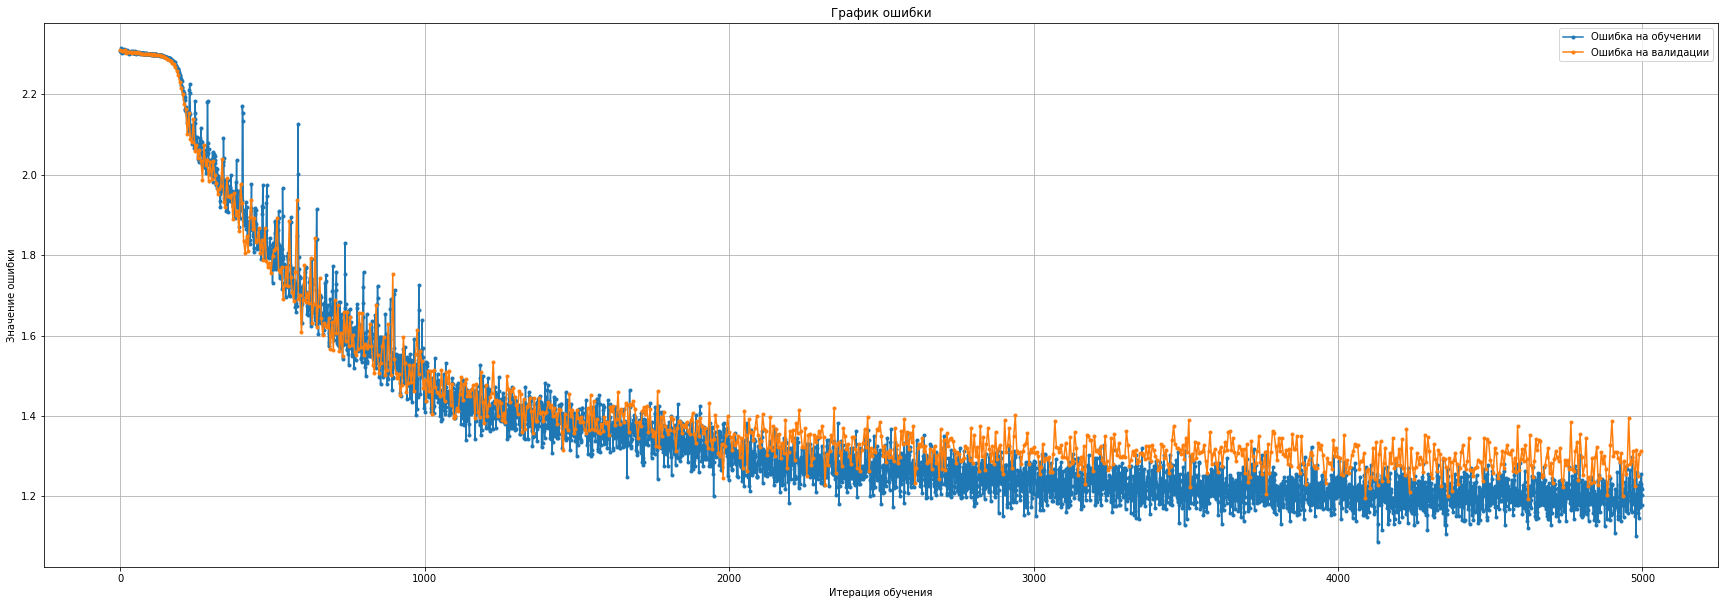

In [146]:
# Напишем цикл обучения модели
from IPython.display import clear_output

# Для ускорения обучения используем видеокарту компьютера или виртуальной машины
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 5000
batch_size = 1000
val_every = 5

model = ResidualModel(
    out_size=10,
    residual_sizes=[(2, 8, 3), (2, 16, 3), (2, 32, 3)],
    linear_sizes=[32],
    activation=torch.nn.ReLU,
    flatten=False,
).to(dtype=x_train.dtype, device=device)  # Важно чтобы все тензоры были одного типа и на одном устройстве

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
)

# Шедулер - отвечает за изменение шага градиентного спуска (постепенно будем уменьшать со временем)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

loss_fn = torch.nn.NLLLoss()

losses = {"train": [], "val": []}

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    
    # Будем на каждой итерации обучения брать не все 50.000 картинок, а лишь случайные batch_size артинок
    batch_pos = torch.randint(high=x_train.shape[0], size=[batch_size])
    
    pred = model(x_train[batch_pos].to(device))  # Так же переносим тензоры на устойство
    loss = loss_fn(pred, y_train[batch_pos].to(device))
    
    loss.backward()
    optimizer.step()
    
    losses["train"].append(loss.item())
    
    # Каждые val_every итераций считаем значение loss на валидации
    if epoch % val_every == 0:
        with torch.no_grad():
            val_batch_pos = torch.randint(high=x_val.shape[0], size=[batch_size])
            val_pred = model(x_val[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_val[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())
        
    # Каждые 1000 итераций уменьшаем шаг градиентного спуска
    if epoch % 1000 == 0:
        scheduler.step()
    
    # Каждые 100 итераций рисуем графики loss-а
    if epoch % 100 == 0:
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
#         plt.yscale("log")
        plt.legend()
        plt.grid()
        plt.show()

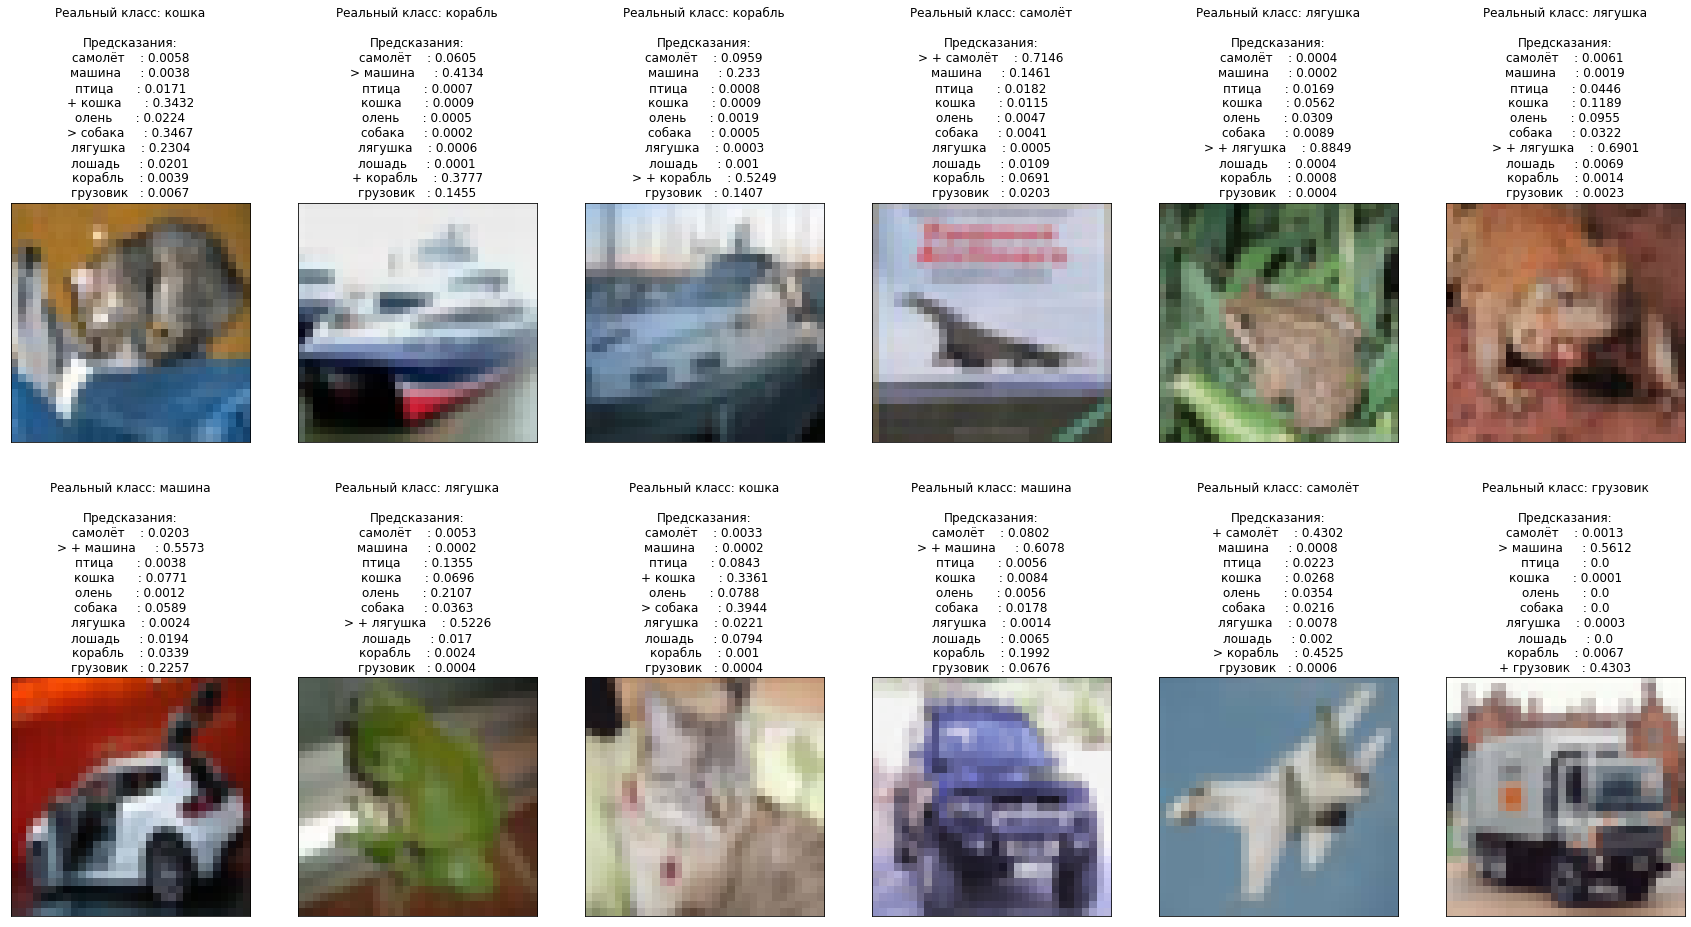

In [157]:
# Посмотрим на предсказания нашей модели на примерах из валидационной выборки
def show_results(model, h=2, w=6):
    with torch.no_grad():
        batch_probs = model(x_val[:h*w].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 8 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(x_val[i])
            title = f'Реальный класс: {classes_ru[y_val[i]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j != y_pred else "> ",
                    "" if j != y_val[i] else "+ ",
                    classes_ru[j],
                    round(prob.item(), 4),
                )
                
            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

show_results(model)